In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("./Electric_Production.csv", index_col= "DATE", parse_dates = True, skipinitialspace = True)
df.head() 

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [4]:
df.tail()

,Value
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [5]:
df.dropna(inplace = True)
df.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


<Axes: xlabel='DATE', ylabel='Value'>

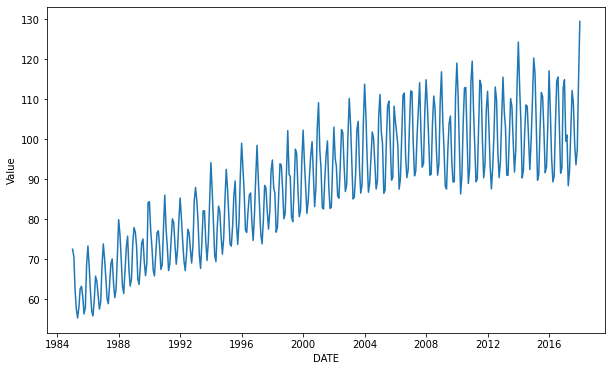

In [6]:
# we plot the data to see if its seasonal
plt.figure(figsize=(10, 6))
sns.lineplot(data= df, x = df.index, y = df.Value)

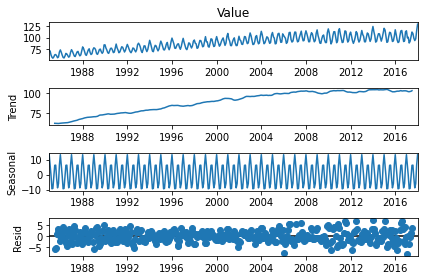

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df["Value"])
results.plot();

In [9]:
len(df)

397

In [10]:
397-12

385

In [11]:
# train and test data
# because we are to use the last 12 months to test on, we will minus 1825 - 12
train = df.iloc[:385]
test = df.iloc[385:]

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(units= 100, activation= "relu", input_shape= (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer= "adam", loss= "mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(generator, epochs= 100)

Epoch 1/100
373/373 [==============================] - 12s 8ms/step - loss: 0.0243
Epoch 2/100
373/373 [==============================] - 3s 7ms/step - loss: 0.0135
Epoch 3/100
373/373 [==============================] - 3s 9ms/step - loss: 0.0077
Epoch 4/100
373/373 [==============================] - 4s 10ms/step - loss: 0.0052
Epoch 5/100
373/373 [==============================] - 3s 8ms/step - loss: 0.0037
Epoch 6/100
373/373 [==============================] - 3s 9ms/step - loss: 0.0029
Epoch 7/100
373/373 [==============================] - 3s 7ms/step - loss: 0.0027
Epoch 8/100
373/373 [==============================] - 4s 10ms/step - loss: 0.0023
Epoch 9/100
373/373 [==============================] - 3s 8ms/step - loss: 0.0024
Epoch 10/100
373/373 [==============================] - 3s 7ms/step - loss: 0.0030
Epoch 11/100
373/373 [==============================] - 3s 8ms/step - loss: 0.0023
Epoch 12/100
373/373 [==============================] - 3s 7ms/step - loss: 0.0023
Epoch 13/1

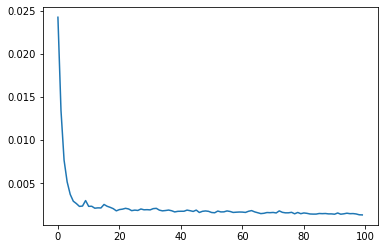

In [17]:
loss_per_epoch = model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [20]:
last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

1/1 [==============================] - 1s 608ms/step


array([[0.731897]], dtype=float32)

In [21]:
scaled_test[0]

array([0.64077645])

In [23]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis =1)

test_predictions

1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 48ms/step


[array([0.731897], dtype=float32),
 array([0.6191251], dtype=float32),
 array([0.49108404], dtype=float32),
 array([0.55160004], dtype=float32),
 array([0.7236494], dtype=float32),
 array([0.85246736], dtype=float32),
 array([0.8175685], dtype=float32),
 array([0.6857144], dtype=float32),
 array([0.54324955], dtype=float32),
 array([0.58159614], dtype=float32),
 array([0.76693094], dtype=float32),
 array([0.85], dtype=float32)]

In [24]:
true_predictions = scaler.inverse_transform(test_predictions)
test["predictions"] = true_predictions

<Axes: xlabel='DATE'>

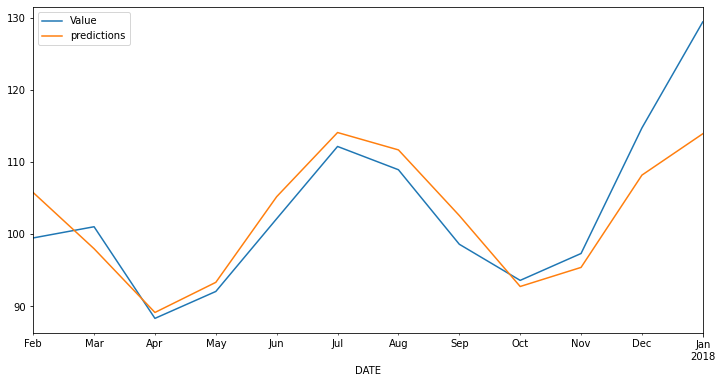

In [27]:
test["predictions"] = true_predictions
test.plot(figsize = (12, 6))

In [31]:
from math import sqrt
rmse = sqrt(mean_squared_error(test["Value"], test["predictions"]))
rmse

5.585843102000047